In [1]:
import cpr_gym
import itertools
import git
import gym
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import time

import warnings
from pandarallel import pandarallel
from stable_baselines3 import PPO

pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count())

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: local-v0.4-106-ga0e66e0


# Run simulations with trained models

In [2]:
def models():
    for m in pathlib.Path("data/models").glob("*-sb3-ppo-*.zip"):
        x = m.stem.split("-sb3-ppo-")
        y = x[1].split("-")
        protocol = y[0]
        if protocol == "nakamoto":
            yield dict(
                model=x[0],
                protocol=y[0],
                k=1,
                reward="btc",
                subblock_selection="n/a",
                gamma=int(y[1].removeprefix("gamma")) / 100,
                path=m,
            )
        elif protocol == "tailstorm" or protocol == "tailstormll":
            yield dict(
                model=x[0],
                protocol=y[0],
                k=int(y[1]),
                reward=y[2],
                subblock_selection=y[3],
                gamma=int(y[4].removeprefix("gamma")) / 100,
                path=m,
            )
        else:
            raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models())

# reuse some trained models for other settings
models = pd.concat(
    [
        models.assign(kind="trained"),
        models.query(
            'protocol == "tailstorm" and subblock_selection == "heuristic"'
        ).assign(kind="reused", subblock_selection="optimal"),
    ],
    ignore_index=True,
)

models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            kind="reused", reward="discount"
        ),
    ]
)

models = pd.concat(
    [
        models,
        models.query("gamma == 0.5").assign(
            kind="reused",
            gamma=0,
        ),
        models.query("gamma == 0.5").assign(
            kind="reused",
            gamma=0.9,
        ),
    ]
)

models

model   protocol  k    reward subblock_selection  gamma  \
0  wandb-352   nakamoto  1       btc                n/a    0.5   
1  wandb-361   nakamoto  1       btc                n/a    0.5   
2  wandb-337  tailstorm  8  constant          heuristic    0.5   
3  wandb-337  tailstorm  8  constant            optimal    0.5   
2  wandb-337  tailstorm  8  discount          heuristic    0.5   
3  wandb-337  tailstorm  8  discount            optimal    0.5   
0  wandb-352   nakamoto  1       btc                n/a    0.0   
1  wandb-361   nakamoto  1       btc                n/a    0.0   
2  wandb-337  tailstorm  8  constant          heuristic    0.0   
3  wandb-337  tailstorm  8  constant            optimal    0.0   
2  wandb-337  tailstorm  8  discount          heuristic    0.0   
3  wandb-337  tailstorm  8  discount            optimal    0.0   
0  wandb-352   nakamoto  1       btc                n/a    0.9   
1  wandb-361   nakamoto  1       btc                n/a    0.9   
2  wandb-337  tailstorm  8  constant          heuristic    0.9   
3  wandb-337  tailstorm  8  constant            optimal    0.9   
2  wandb-337  tailstorm  8  discount          heuristic    0.9   
3  wandb-337  tailstorm  8  discount            optimal    0.9   

                                                path     kind  
0  data/models/wandb-352-sb3-ppo-nakamoto-gamma50...  trained  
1  data/models/wandb-361-sb3-ppo-nakamoto-gamma50...  trained  
2  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...  trained  
3  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
2  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
3  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
0  data/models/wandb-352-sb3-ppo-nakamoto-gamma50...   reused  
1  data/models/wandb-361-sb3-ppo-nakamoto-gamma50...   reused  
2  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
3  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
2  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
3  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
0  data/models/wandb-352-sb3-ppo-nakamoto-gamma50...   reused  
1  data/models/wandb-361-sb3-ppo-nakamoto-gamma50...   reused  
2  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
3  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
2  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused  
3  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused

In [3]:
protocols = dict(
    nakamoto=(cpr_gym.protocols.nakamoto, []),
    tailstorm=(cpr_gym.protocols.tailstorm, ["k", "reward", "subblock_selection"]),
    tailstormll=(cpr_gym.protocols.tailstormll, ["k", "reward", "subblock_selection"]),
)
episode_len = 2048
n_episodes = 5
alpha = np.arange(0.1, 0.501, 0.025)


def episodes():
    for i in range(0, n_episodes):
        for a in alpha:
            yield models.assign(episode=i, alpha=a)


episodes = pd.concat(episodes(), ignore_index=True)


def sparse_env(x):
    proto, proto_args = protocols[x.protocol]
    proto_args = {k: x[k] for k in proto_args}
    defenders = np.ceil((1 - x.alpha) / (1 - x.gamma))
    env = gym.make(
        "cpr_gym:core-v0",
        proto=proto(**proto_args),
        gamma=x.gamma,
        defenders=defenders,
        alpha=x.alpha,
        max_time=episode_len,
        max_steps=episode_len * 10000,
    )
    return env


loaded = {}


def load(path):
    if path in loaded.keys():
        return loaded[path]
    else:
        m = PPO.load(path)
        loaded[path] = m
        return m


def observe_episode(info):
    return pd.Series(
        {
            k: info[k]
            for k in [
                "episode_reward_attacker",
                "episode_chain_time",
                "episode_progress",
            ]
        }
    )


def measure(x):
    env = sparse_env(x)
    model = load(x.path)
    obs = env.reset()
    done = False
    while not done:
        extobs = np.append(obs, [x.alpha])
        action, _ = model.predict(extobs, deterministic=True)
        obs, _reward, done, info = env.step(action)
    return observe_episode(info)


# run simulations
# results = episodes.apply(
results = episodes.parallel_apply(
    measure,
    axis=1,
)
rl_episodes = pd.concat([episodes, results], axis=1)
rl_episodes

model   protocol  k    reward subblock_selection  gamma  \
0     wandb-352   nakamoto  1       btc                n/a    0.5   
1     wandb-361   nakamoto  1       btc                n/a    0.5   
2     wandb-337  tailstorm  8  constant          heuristic    0.5   
3     wandb-337  tailstorm  8  constant            optimal    0.5   
4     wandb-337  tailstorm  8  discount          heuristic    0.5   
...         ...        ... ..       ...                ...    ...   
1525  wandb-361   nakamoto  1       btc                n/a    0.9   
1526  wandb-337  tailstorm  8  constant          heuristic    0.9   
1527  wandb-337  tailstorm  8  constant            optimal    0.9   
1528  wandb-337  tailstorm  8  discount          heuristic    0.9   
1529  wandb-337  tailstorm  8  discount            optimal    0.9   

                                                   path     kind  episode  \
0     data/models/wandb-352-sb3-ppo-nakamoto-gamma50...  trained        0   
1     data/models/wandb-361-sb3-ppo-nakamoto-gamma50...  trained        0   
2     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...  trained        0   
3     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused        0   
4     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused        0   
...                                                 ...      ...      ...   
1525  data/models/wandb-361-sb3-ppo-nakamoto-gamma50...   reused        4   
1526  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused        4   
1527  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused        4   
1528  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused        4   
1529  data/models/wandb-337-sb3-ppo-tailstorm-8-cons...   reused        4   

      alpha  episode_reward_attacker  episode_chain_time  episode_progress  
0       0.1                  195.000         2048.231227            2016.0  
1       0.1                  212.000         2048.301141            2016.0  
2       0.1                  188.000         2044.131245            2024.0  
3       0.1                  183.000         2045.833849            2088.0  
4       0.1                  170.375         2047.001902            2088.0  
...     ...                      ...                 ...               ...  
1525    0.5                 1054.000         2042.212354            1061.0  
1526    0.5                   13.000         2042.124660            1016.0  
1527    0.5                  969.000         2040.311306            1096.0  
1528    0.5                  975.875         2038.127594            1064.0  
1529    0.5                 1063.125         2045.432948            1080.0  

[1530 rows x 13 columns]

## Patrik-style rewards

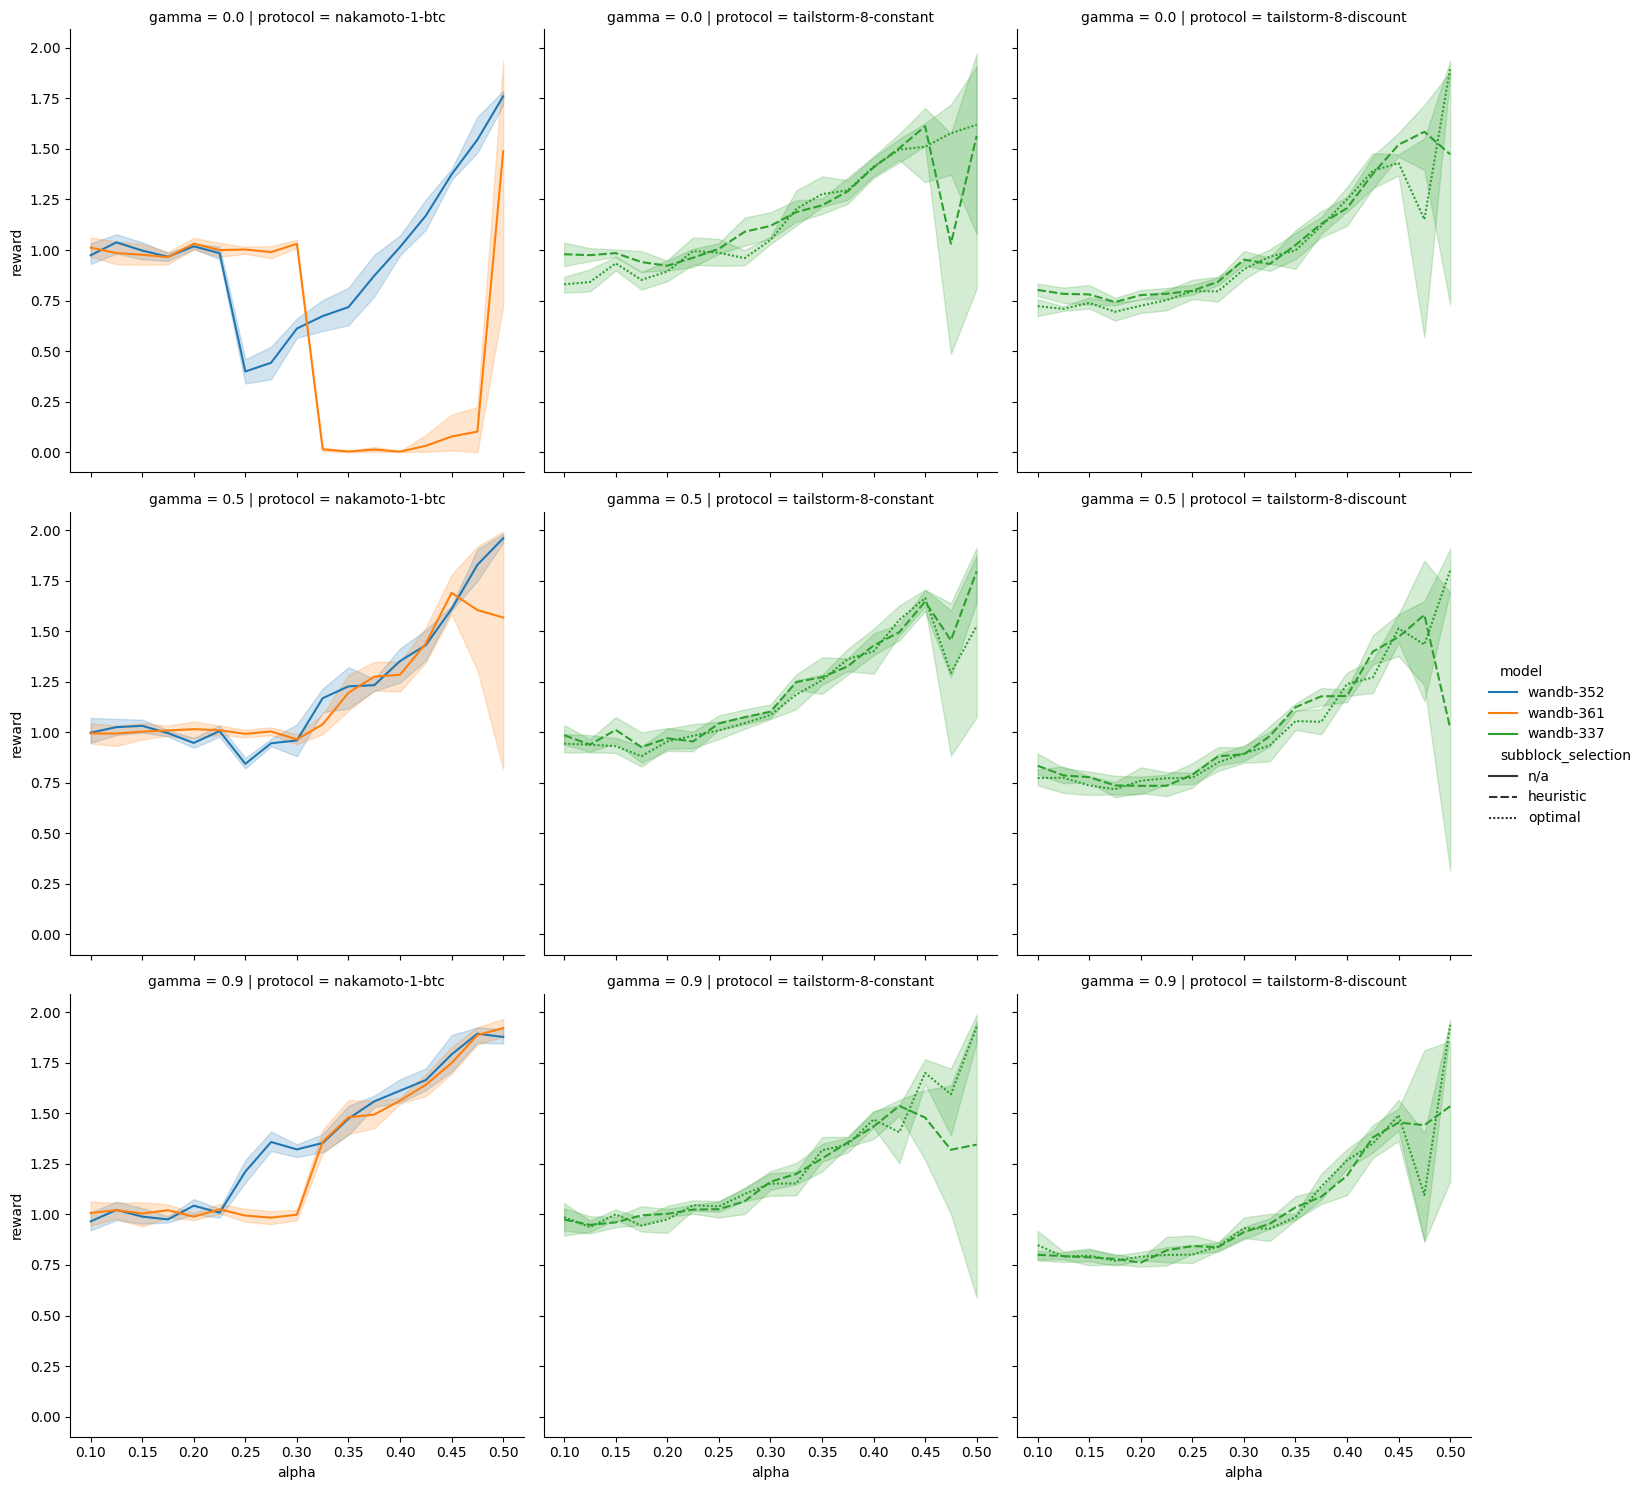

In [4]:
d = rl_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
    row="gamma",
)

## Ben-style rewards

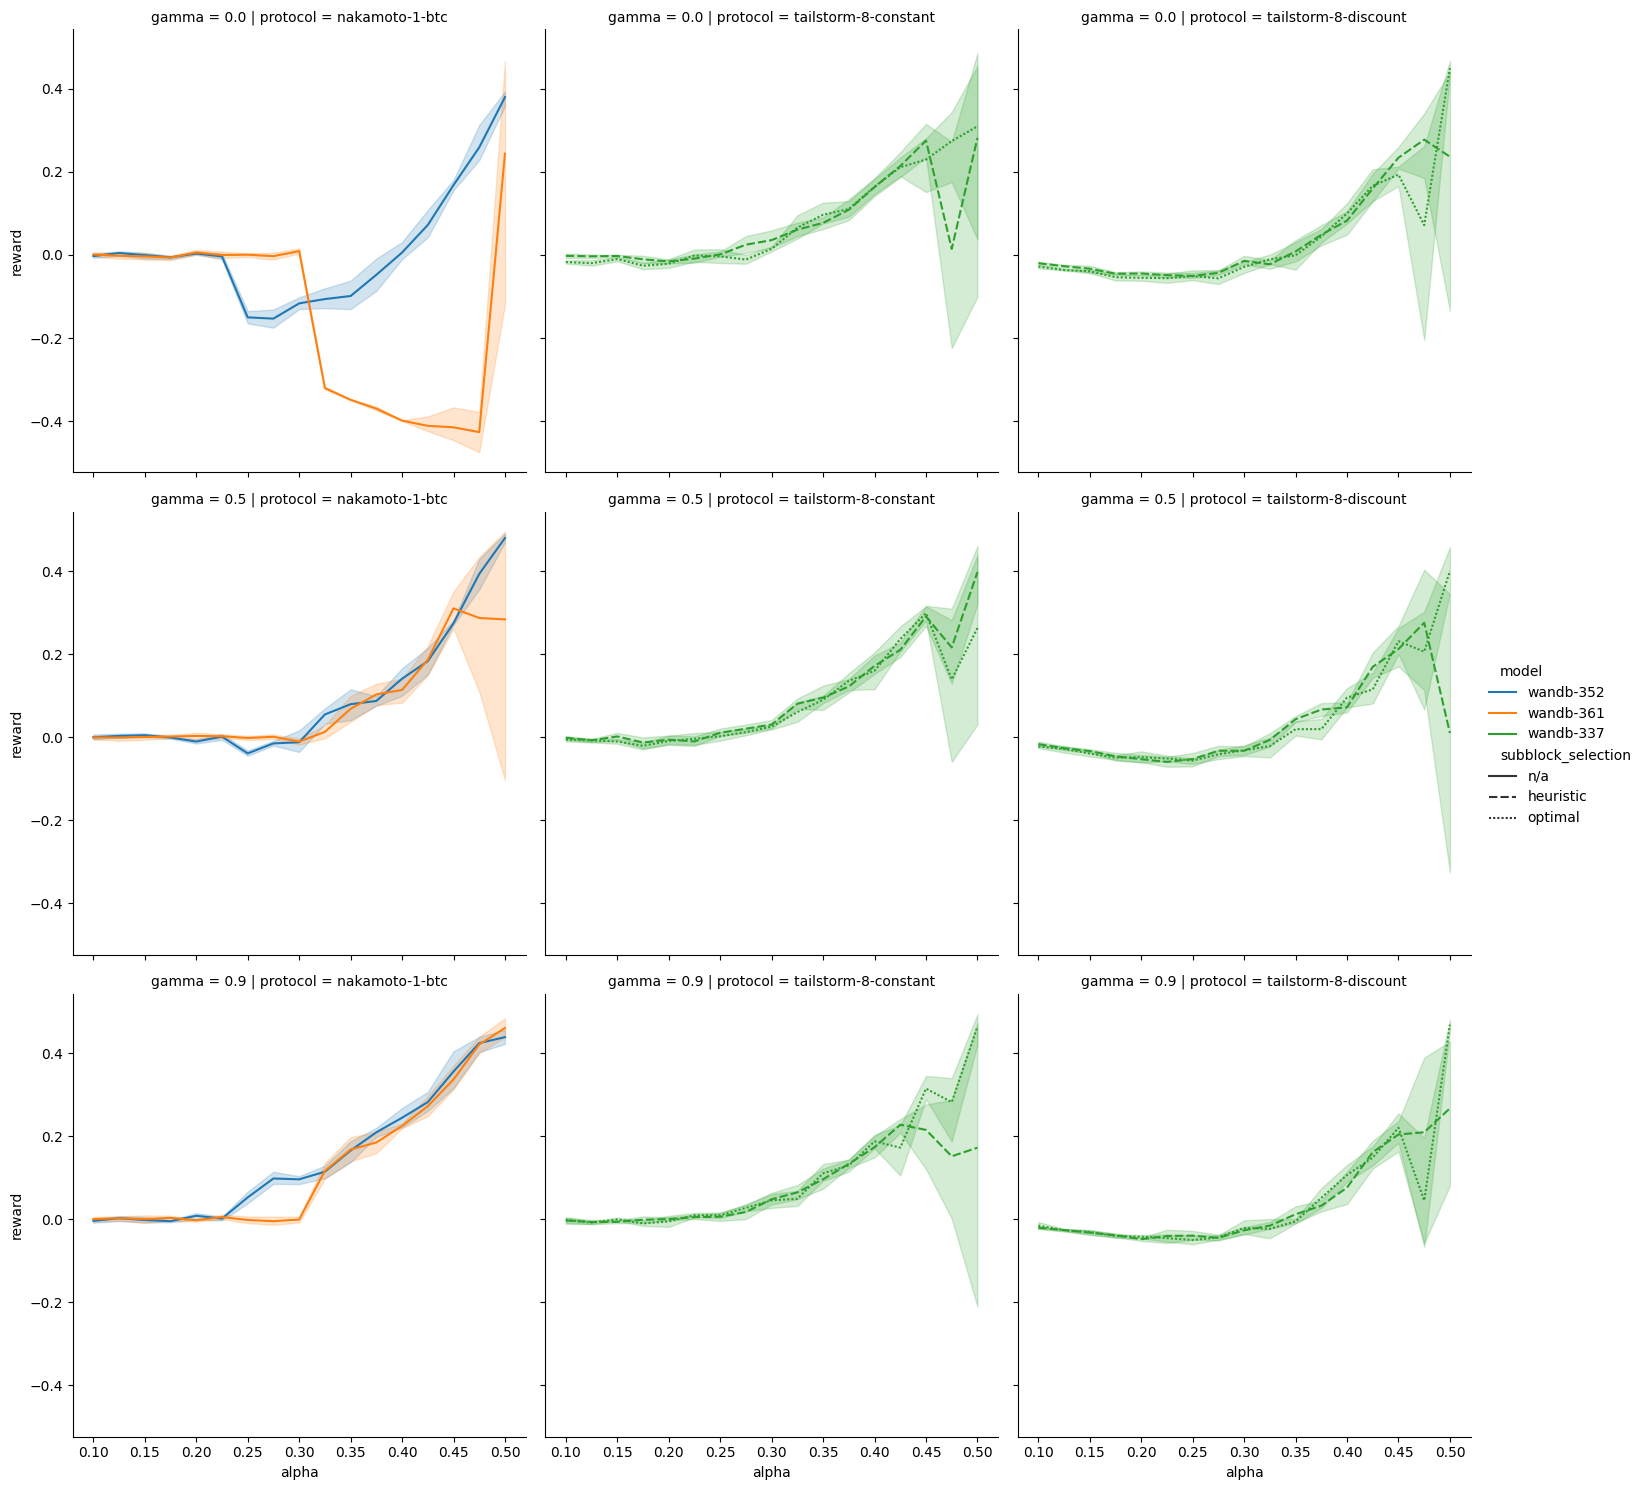

In [5]:
d = rl_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
    row="gamma",
)

# Simulate hard-coded policies

In [6]:
scenarios = models[
    ["protocol", "k", "reward", "subblock_selection", "gamma"]
].drop_duplicates()


def episodes():
    for _idx, x in scenarios.iterrows():
        x = x.copy()
        x["alpha"] = 0.0
        env = sparse_env(x)
        for p in env.policies():
            for i in range(0, n_episodes):
                for a in alpha:
                    x = x.copy()
                    x["policy"] = p
                    x["alpha"] = a
                    x["episode"] = i
                    yield x


episodes = pd.DataFrame(episodes()).reset_index(drop=True)


def measure(x):
    env = sparse_env(x)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, x.policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


# run simulations
results = episodes.parallel_apply(
    measure,
    axis=1,
)
hc_episodes = pd.concat([episodes, results], axis=1)
hc_episodes

protocol  k    reward subblock_selection  gamma  alpha  \
0      nakamoto  1       btc                n/a    0.5  0.100   
1      nakamoto  1       btc                n/a    0.5  0.125   
2      nakamoto  1       btc                n/a    0.5  0.150   
3      nakamoto  1       btc                n/a    0.5  0.175   
4      nakamoto  1       btc                n/a    0.5  0.200   
...         ... ..       ...                ...    ...    ...   
5095  tailstorm  8  discount            optimal    0.9  0.400   
5096  tailstorm  8  discount            optimal    0.9  0.425   
5097  tailstorm  8  discount            optimal    0.9  0.450   
5098  tailstorm  8  discount            optimal    0.9  0.475   
5099  tailstorm  8  discount            optimal    0.9  0.500   

                    policy  episode  episode_reward_attacker  \
0     sapirshtein-2016-sm1        0                    127.0   
1     sapirshtein-2016-sm1        0                    161.0   
2     sapirshtein-2016-sm1        0                    237.0   
3     sapirshtein-2016-sm1        0                    269.0   
4     sapirshtein-2016-sm1        0                    292.0   
...                    ...      ...                      ...   
5095                honest        4                    844.0   
5096                honest        4                    875.0   
5097                honest        4                    894.0   
5098                honest        4                    976.0   
5099                honest        4                   1041.0   

      episode_chain_time  episode_progress  
0            2046.608345            1905.0  
1            2049.621148            1802.0  
2            2048.999710            1767.0  
3            2049.364511            1820.0  
4            2047.421616            1785.0  
...                  ...               ...  
5095         2038.916694            2072.0  
5096         2043.537342            2024.0  
5097         2044.770546            2056.0  
5098         2043.732474            2056.0  
5099         2047.389091            2088.0  

[5100 rows x 11 columns]

# Determine best hard-coded policies

In [7]:
key = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
d = hc_episodes
d = d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
mean_reward = d.groupby(key + ["policy"]).episode_reward.mean().reset_index()
opt_idx = mean_reward.reset_index().groupby(key).episode_reward.idxmax()
opt_policies = mean_reward.iloc[opt_idx].set_index(key)
opt_policies

policy  \
protocol  k reward   subblock_selection gamma alpha                     
nakamoto  1 btc      n/a                0.0   0.100            honest   
                                              0.125            honest   
                                              0.150            honest   
                                              0.175            honest   
                                              0.200            honest   
...                                                               ...   
tailstorm 8 discount optimal            0.9   0.400  override-catchup   
                                              0.425  override-catchup   
                                              0.450  override-catchup   
                                              0.475  override-catchup   
                                              0.500  override-catchup   

                                                     episode_reward  
protocol  k reward   subblock_selection gamma alpha                  
nakamoto  1 btc      n/a                0.0   0.100        0.106038  
                                              0.125        0.124505  
                                              0.150        0.153821  
                                              0.175        0.173592  
                                              0.200        0.207214  
...                                                             ...  
tailstorm 8 discount optimal            0.9   0.400        0.434528  
                                              0.425        0.492172  
                                              0.450        0.560094  
                                              0.475        0.671687  
                                              0.500        0.874493  

[255 rows x 2 columns]

In [8]:
mhc_episodes = (
    hc_episodes.join(opt_policies.policy, on=key, rsuffix="_opt")
    .query("policy == policy_opt")
    .reset_index(drop=True)
    .drop(columns=["policy_opt"])
    .assign(model="max-hard-coded", kind="hard-coded")
)
episodes = pd.concat([rl_episodes, mhc_episodes], axis=0, ignore_index=True)
episodes

model   protocol  k    reward subblock_selection  gamma  \
0          wandb-352   nakamoto  1       btc                n/a    0.5   
1          wandb-361   nakamoto  1       btc                n/a    0.5   
2          wandb-337  tailstorm  8  constant          heuristic    0.5   
3          wandb-337  tailstorm  8  constant            optimal    0.5   
4          wandb-337  tailstorm  8  discount          heuristic    0.5   
...              ...        ... ..       ...                ...    ...   
2800  max-hard-coded  tailstorm  8  discount            optimal    0.9   
2801  max-hard-coded  tailstorm  8  discount            optimal    0.9   
2802  max-hard-coded  tailstorm  8  discount            optimal    0.9   
2803  max-hard-coded  tailstorm  8  discount            optimal    0.9   
2804  max-hard-coded  tailstorm  8  discount            optimal    0.9   

                                                   path        kind  episode  \
0     data/models/wandb-352-sb3-ppo-nakamoto-gamma50...     trained        0   
1     data/models/wandb-361-sb3-ppo-nakamoto-gamma50...     trained        0   
2     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...     trained        0   
3     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...      reused        0   
4     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...      reused        0   
...                                                 ...         ...      ...   
2800                                                NaN  hard-coded        4   
2801                                                NaN  hard-coded        4   
2802                                                NaN  hard-coded        4   
2803                                                NaN  hard-coded        4   
2804                                                NaN  hard-coded        4   

      alpha  episode_reward_attacker  episode_chain_time  episode_progress  \
0     0.100                  195.000         2048.231227            2016.0   
1     0.100                  212.000         2048.301141            2016.0   
2     0.100                  188.000         2044.131245            2024.0   
3     0.100                  183.000         2045.833849            2088.0   
4     0.100                  170.375         2047.001902            2088.0   
...     ...                      ...                 ...               ...   
2800  0.275                  580.000         2045.523040            2088.0   
2801  0.300                  634.000         2046.838204            2032.0   
2802  0.325                  670.000         2041.838790            2032.0   
2803  0.350                  713.000         2041.879816            2056.0   
2804  0.375                  800.000         2044.293817            2128.0   

      policy  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
2800  honest  
2801  honest  
2802  honest  
2803  honest  
2804  honest  

[2805 rows x 14 columns]

# Compare RL against best hard-coded

## Reward per progress (in DAA equilibrium)

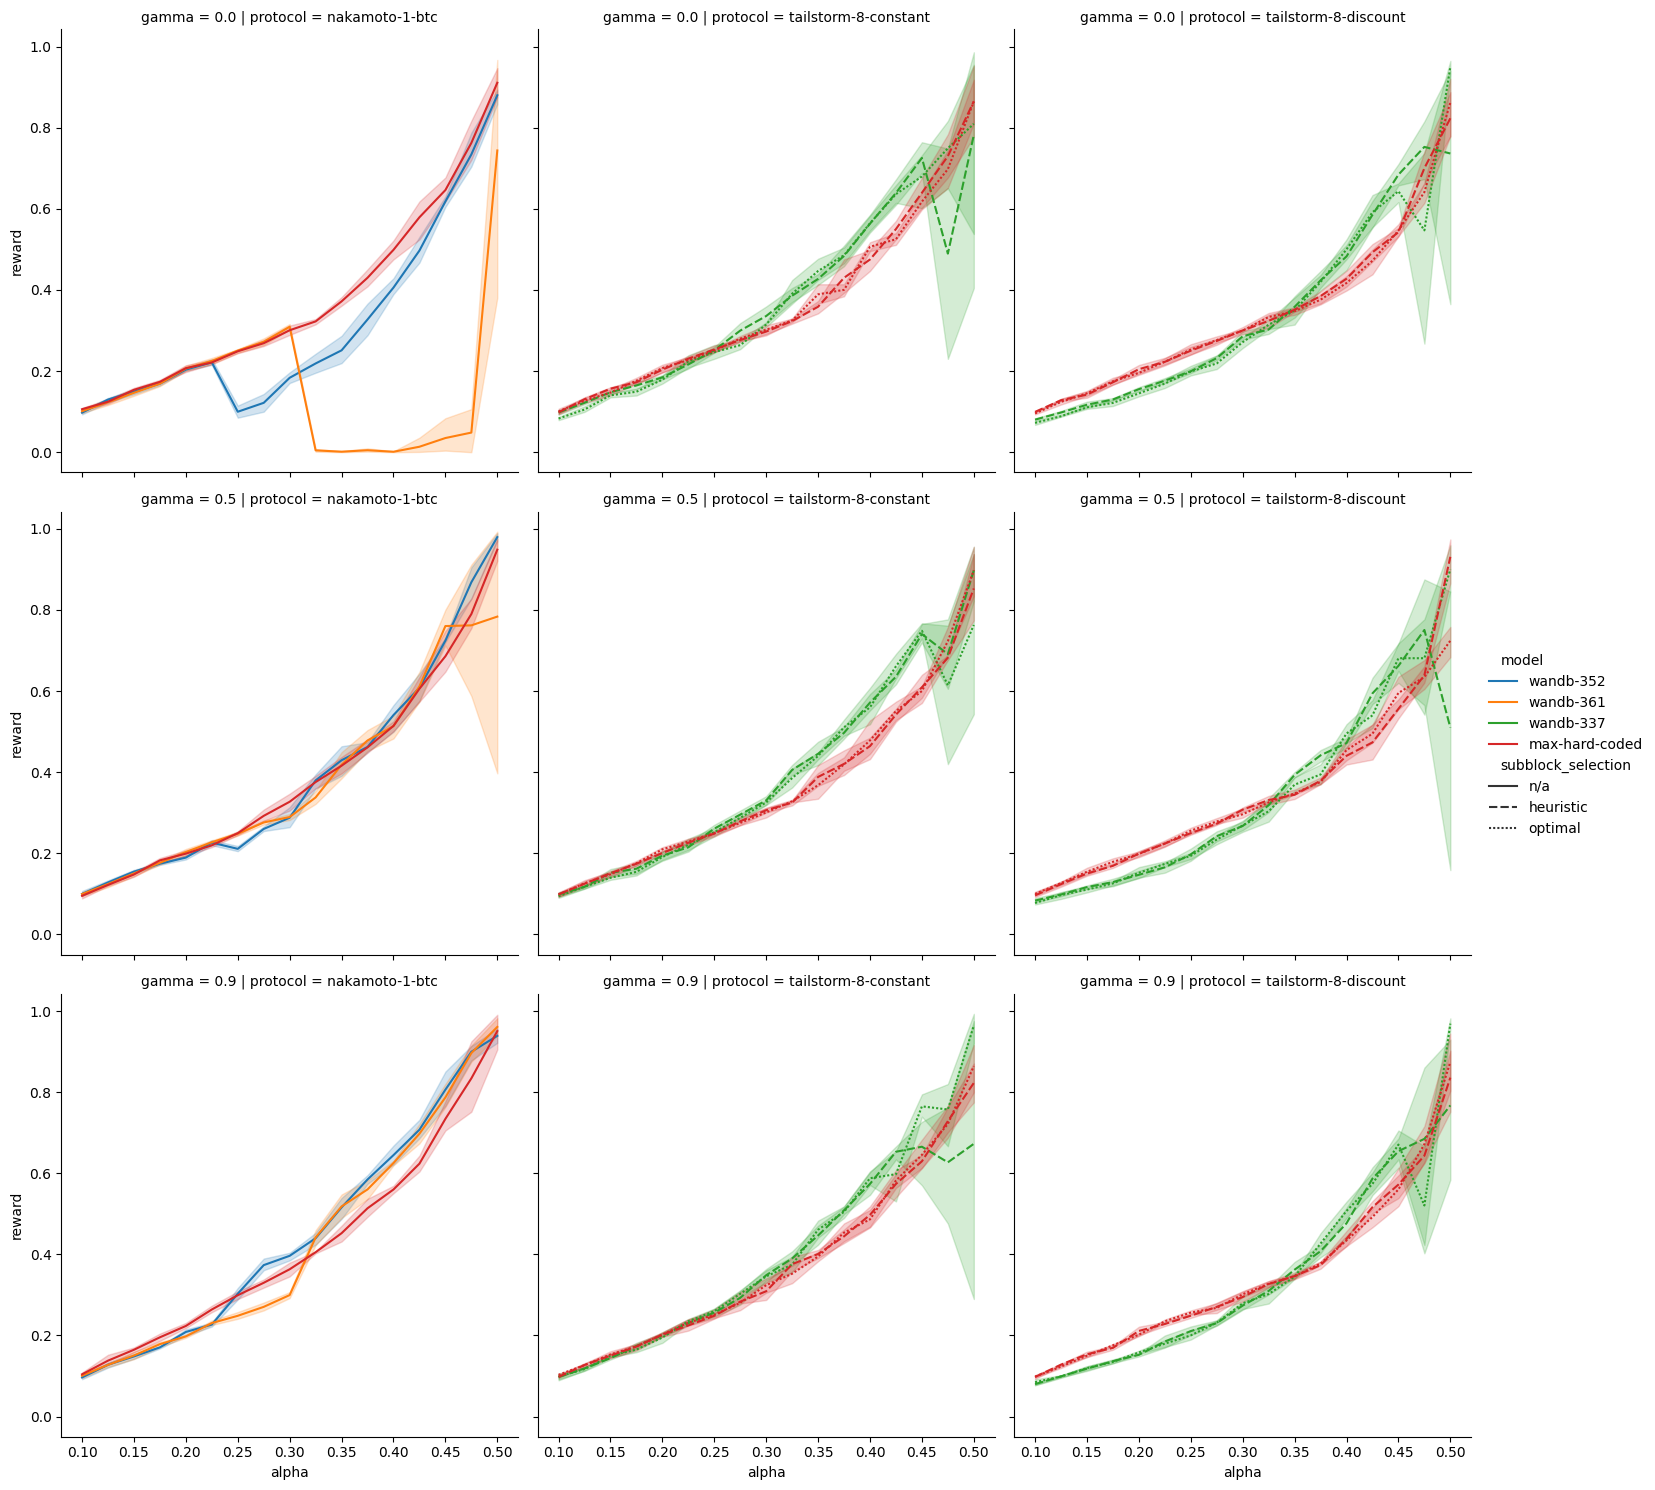

In [9]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
    row="gamma",
)

## Reward, Patrik-style

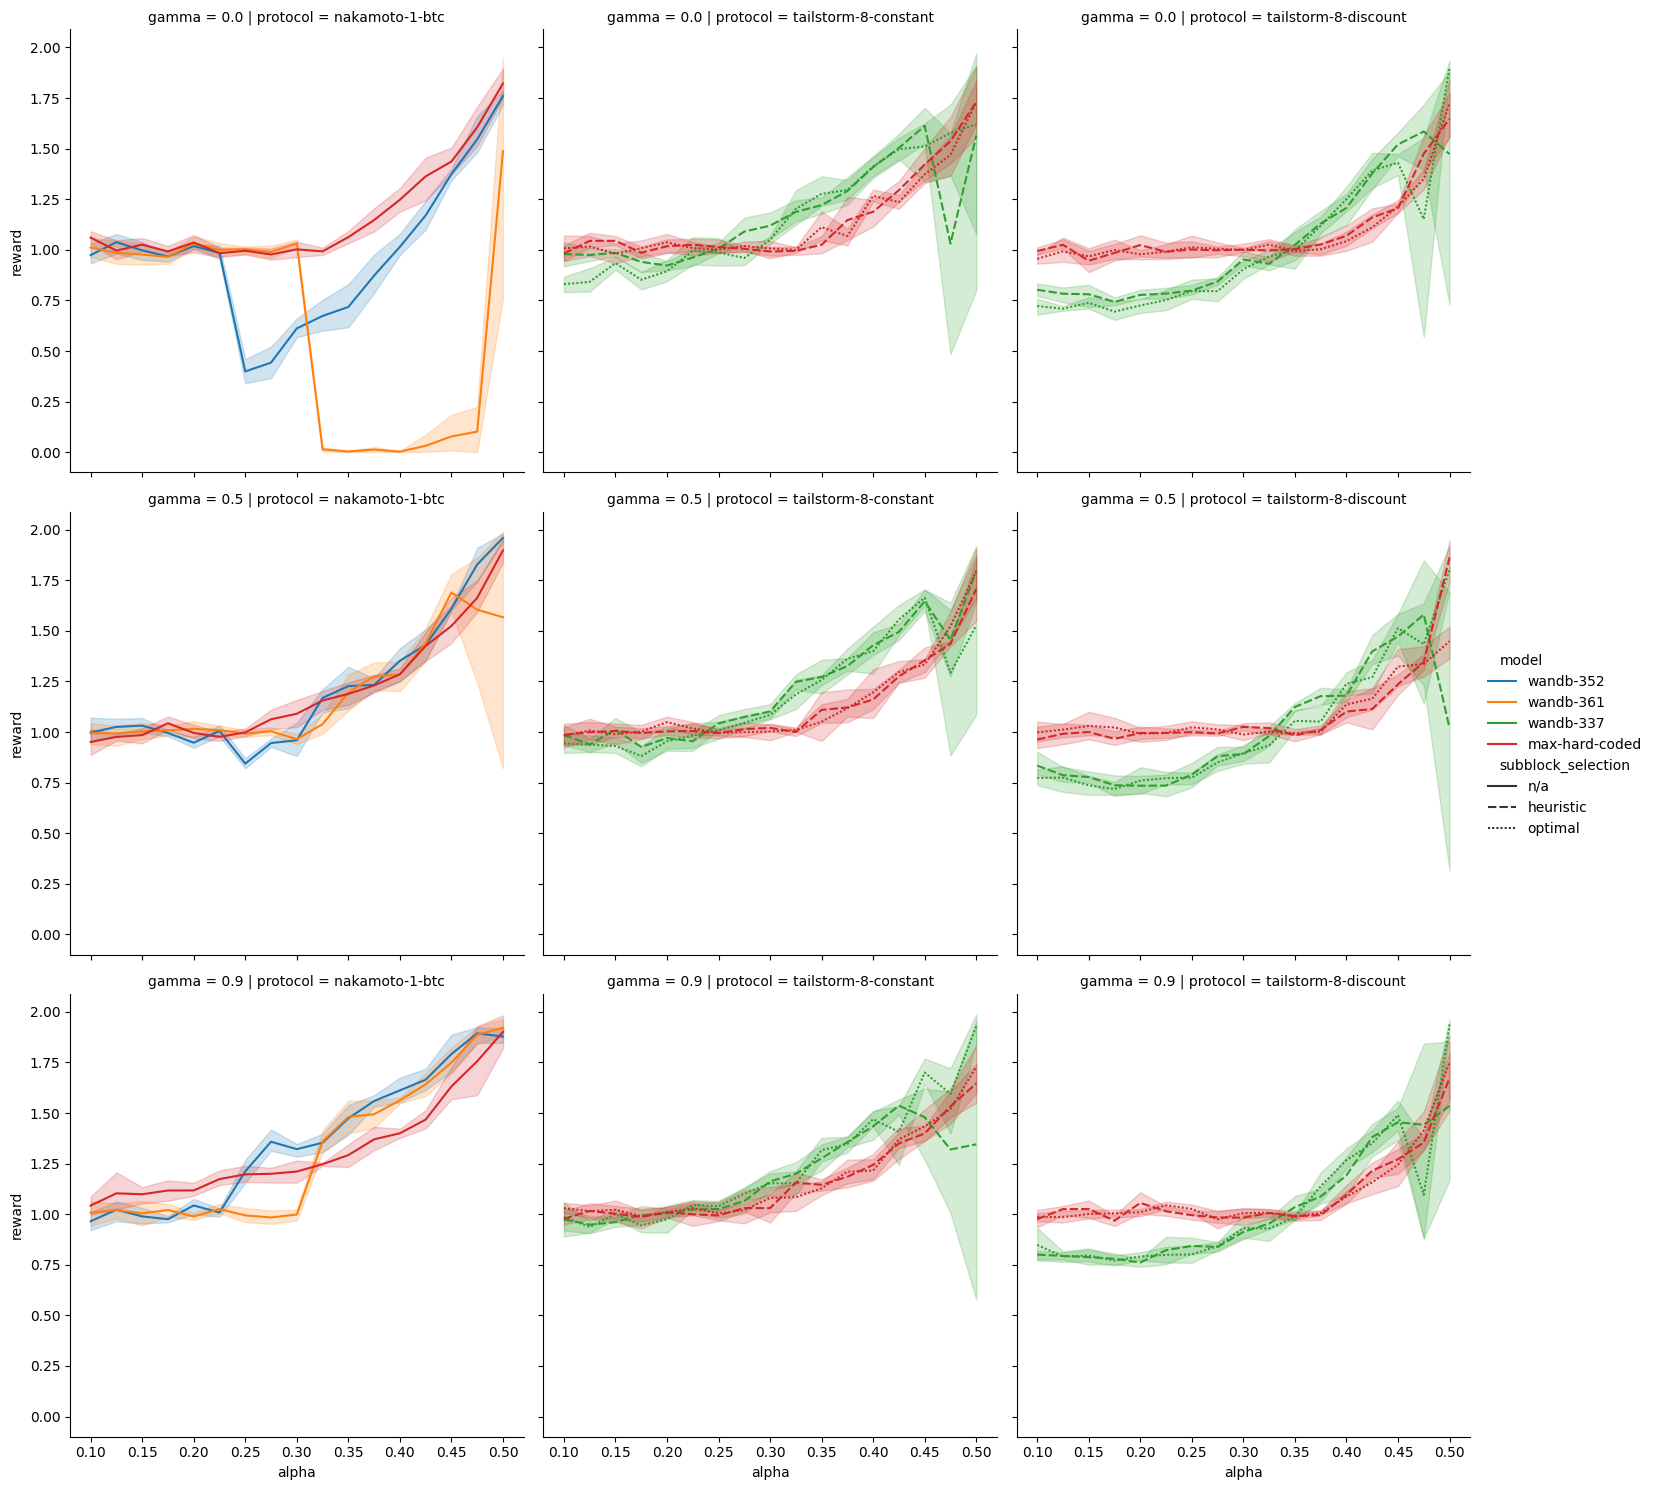

In [10]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
    row="gamma",
)

## Reward, Ben-style

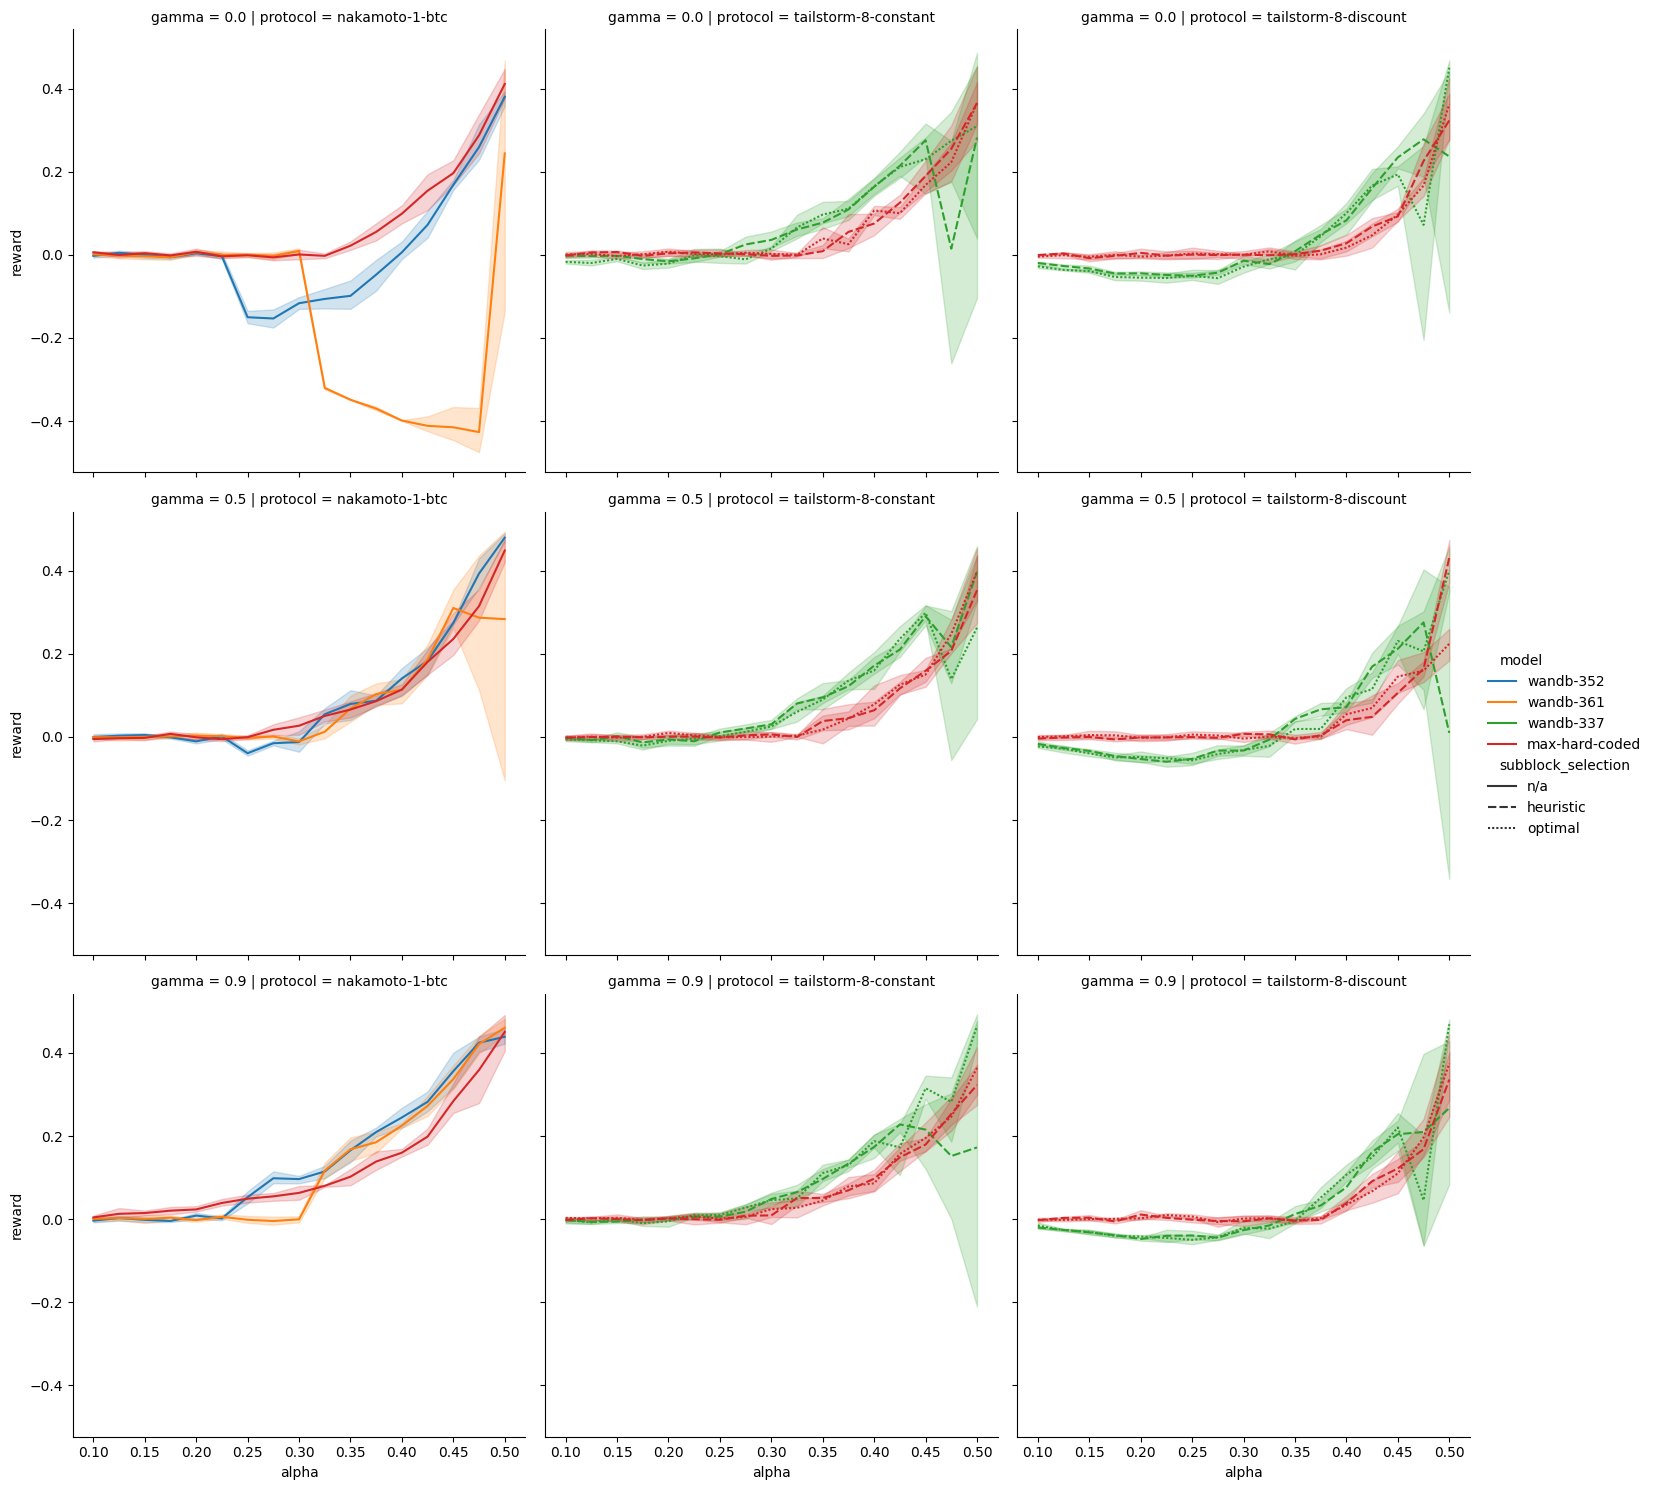

In [11]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
    row="gamma",
)

## Orphans

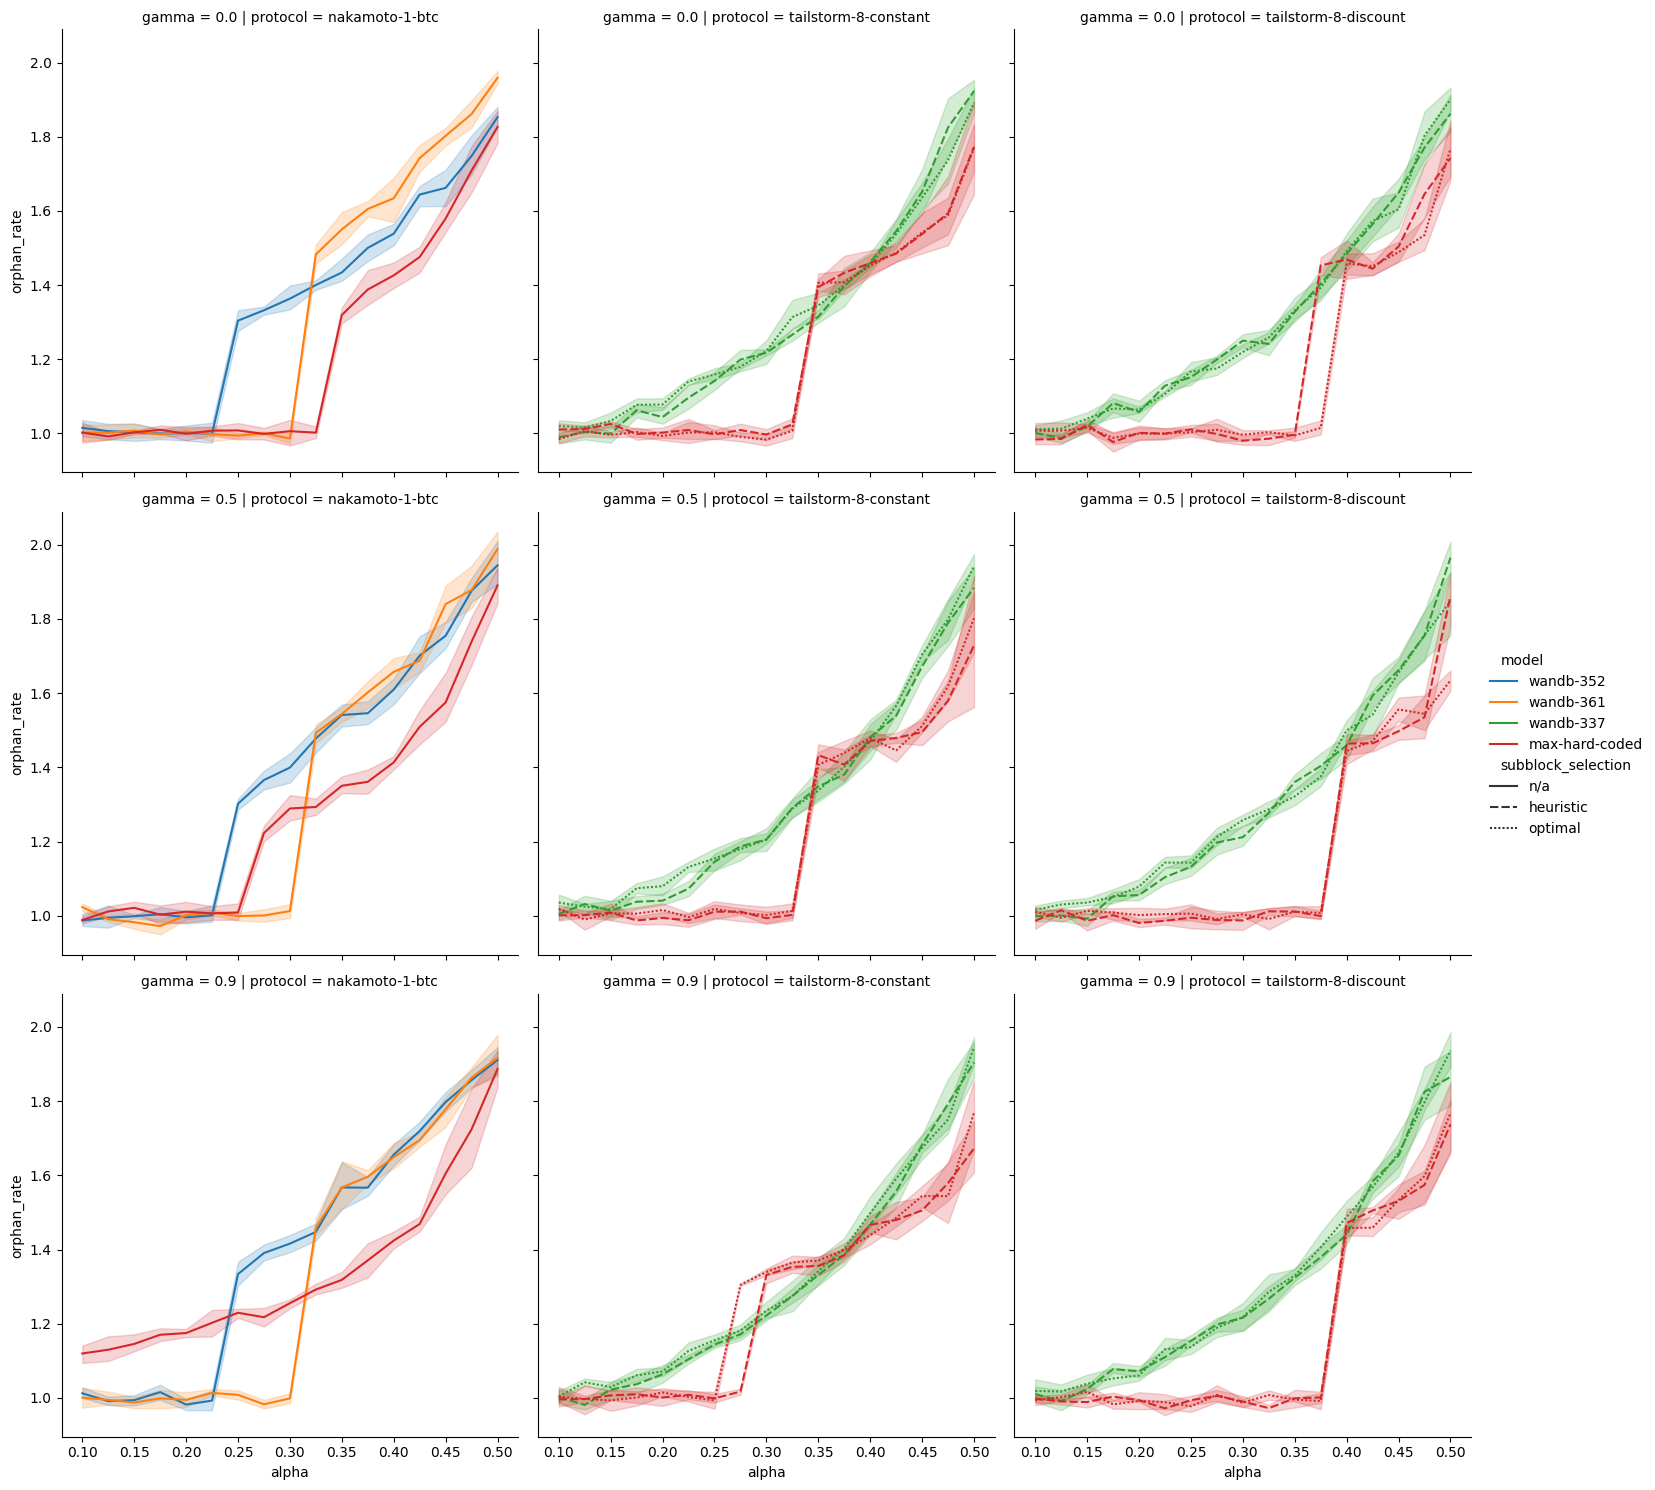

In [12]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        orphan_rate=d.episode_chain_time / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="orphan_rate",
    hue="model",
    style="subblock_selection",
    col="protocol",
    row="gamma",
)

# Find best known strategies; compare protocols

In [13]:
key = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
d = episodes
d = d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
mean_reward = d.groupby(key + ["model"]).episode_reward.mean().reset_index()
opt_idx = mean_reward.reset_index().groupby(key).episode_reward.idxmax()
opt_models = mean_reward.iloc[opt_idx].set_index(key)
opt_models

model  \
protocol  k reward   subblock_selection gamma alpha                   
nakamoto  1 btc      n/a                0.0   0.100  max-hard-coded   
                                              0.125       wandb-352   
                                              0.150  max-hard-coded   
                                              0.175  max-hard-coded   
                                              0.200  max-hard-coded   
...                                                             ...   
tailstorm 8 discount optimal            0.9   0.400       wandb-337   
                                              0.425       wandb-337   
                                              0.450       wandb-337   
                                              0.475  max-hard-coded   
                                              0.500       wandb-337   

                                                     episode_reward  
protocol  k reward   subblock_selection gamma alpha                  
nakamoto  1 btc      n/a                0.0   0.100        0.106038  
                                              0.125        0.129751  
                                              0.150        0.153821  
                                              0.175        0.173592  
                                              0.200        0.207214  
...                                                             ...  
tailstorm 8 discount optimal            0.9   0.400        0.507001  
                                              0.425        0.573835  
                                              0.450        0.670670  
                                              0.475        0.671687  
                                              0.500        0.968905  

[255 rows x 2 columns]

In [14]:
mm_episodes = (
    episodes.join(opt_models.model, on=key, rsuffix="_opt")
    .query("model == model_opt")
    .reset_index(drop=True)
    .drop(columns=["policy", "model_opt"])
)
mm_episodes

model   protocol  k    reward subblock_selection  gamma  \
0          wandb-352   nakamoto  1       btc                n/a    0.5   
1          wandb-352   nakamoto  1       btc                n/a    0.5   
2          wandb-352   nakamoto  1       btc                n/a    0.0   
3          wandb-352   nakamoto  1       btc                n/a    0.5   
4          wandb-337  tailstorm  8  constant          heuristic    0.5   
...              ...        ... ..       ...                ...    ...   
1270  max-hard-coded  tailstorm  8  discount            optimal    0.9   
1271  max-hard-coded  tailstorm  8  discount            optimal    0.9   
1272  max-hard-coded  tailstorm  8  discount            optimal    0.9   
1273  max-hard-coded  tailstorm  8  discount            optimal    0.9   
1274  max-hard-coded  tailstorm  8  discount            optimal    0.9   

                                                   path        kind  episode  \
0     data/models/wandb-352-sb3-ppo-nakamoto-gamma50...     trained        0   
1     data/models/wandb-352-sb3-ppo-nakamoto-gamma50...     trained        0   
2     data/models/wandb-352-sb3-ppo-nakamoto-gamma50...      reused        0   
3     data/models/wandb-352-sb3-ppo-nakamoto-gamma50...     trained        0   
4     data/models/wandb-337-sb3-ppo-tailstorm-8-cons...     trained        0   
...                                                 ...         ...      ...   
1270                                                NaN  hard-coded        4   
1271                                                NaN  hard-coded        4   
1272                                                NaN  hard-coded        4   
1273                                                NaN  hard-coded        4   
1274                                                NaN  hard-coded        4   

      alpha  episode_reward_attacker  episode_chain_time  episode_progress  
0     0.100                    195.0         2048.231227            2016.0  
1     0.125                    269.0         2050.110302            2149.0  
2     0.125                    260.0         2048.007681            1976.0  
3     0.150                    334.0         2047.433902            2050.0  
4     0.150                    332.0         2041.490131            2072.0  
...     ...                      ...                 ...               ...  
1270  0.250                    526.0         2043.681269            2048.0  
1271  0.275                    580.0         2045.523040            2088.0  
1272  0.300                    634.0         2046.838204            2032.0  
1273  0.325                    670.0         2041.838790            2032.0  
1274  0.350                    713.0         2041.879816            2056.0  

[1275 rows x 13 columns]

## Reward per progress (in DAA equilibrium)

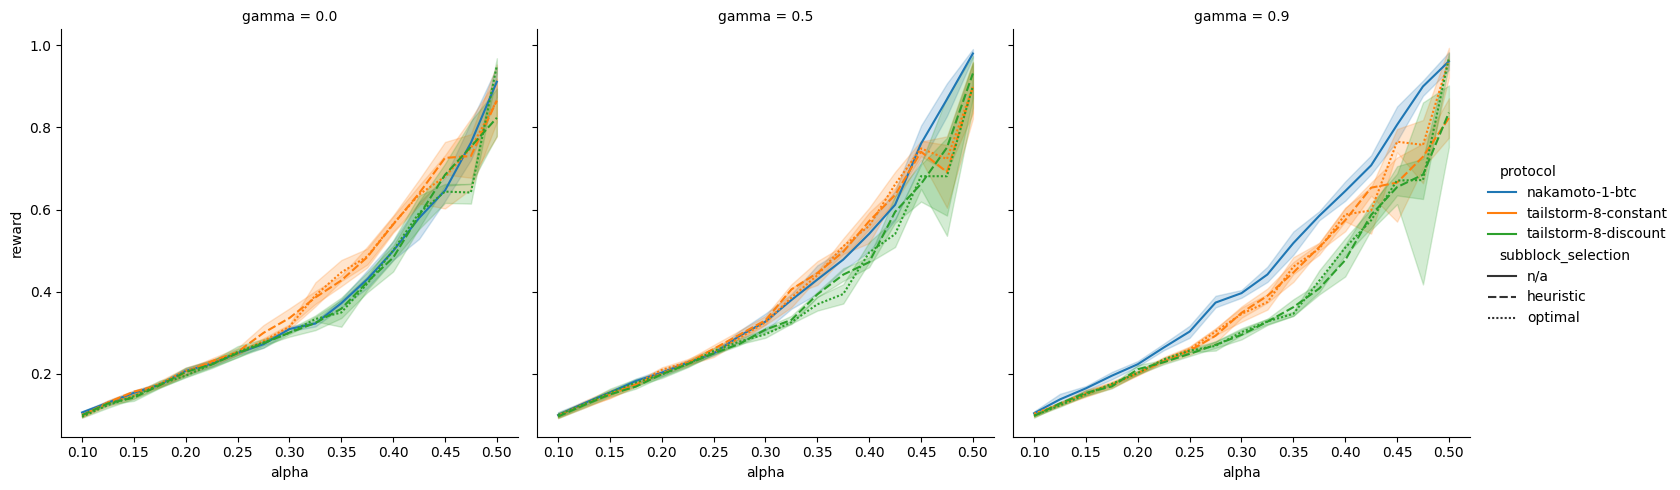

In [20]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Reward, Patrik-style

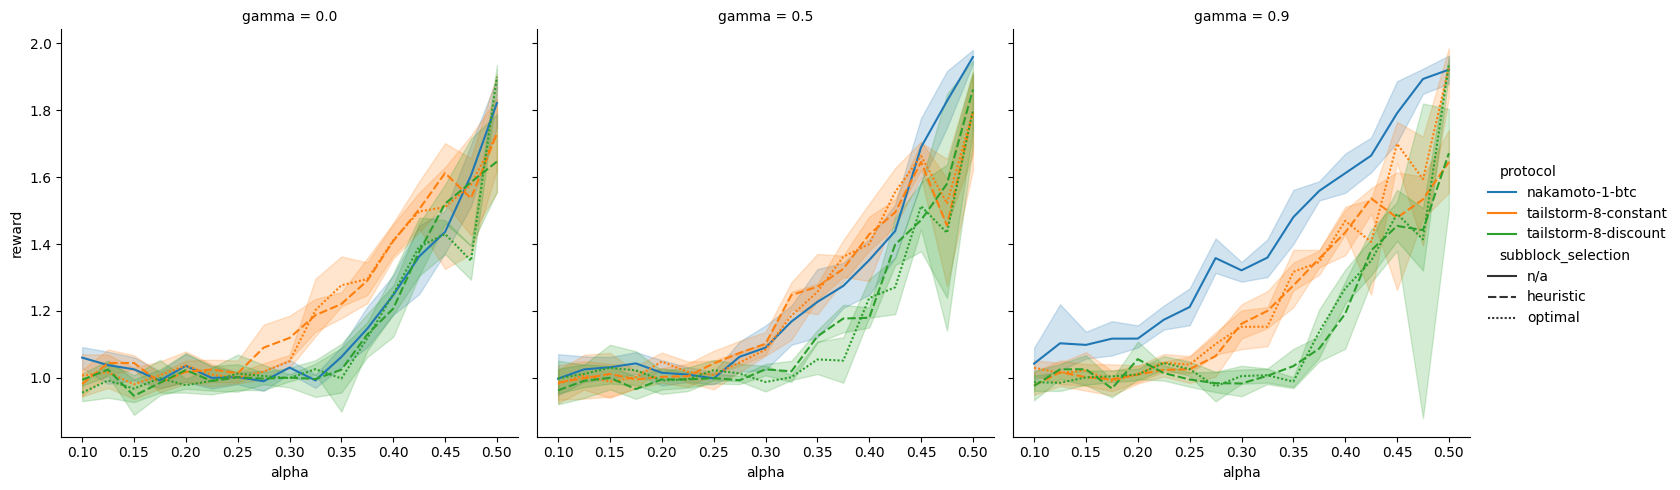

In [21]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Reward, Ben-style

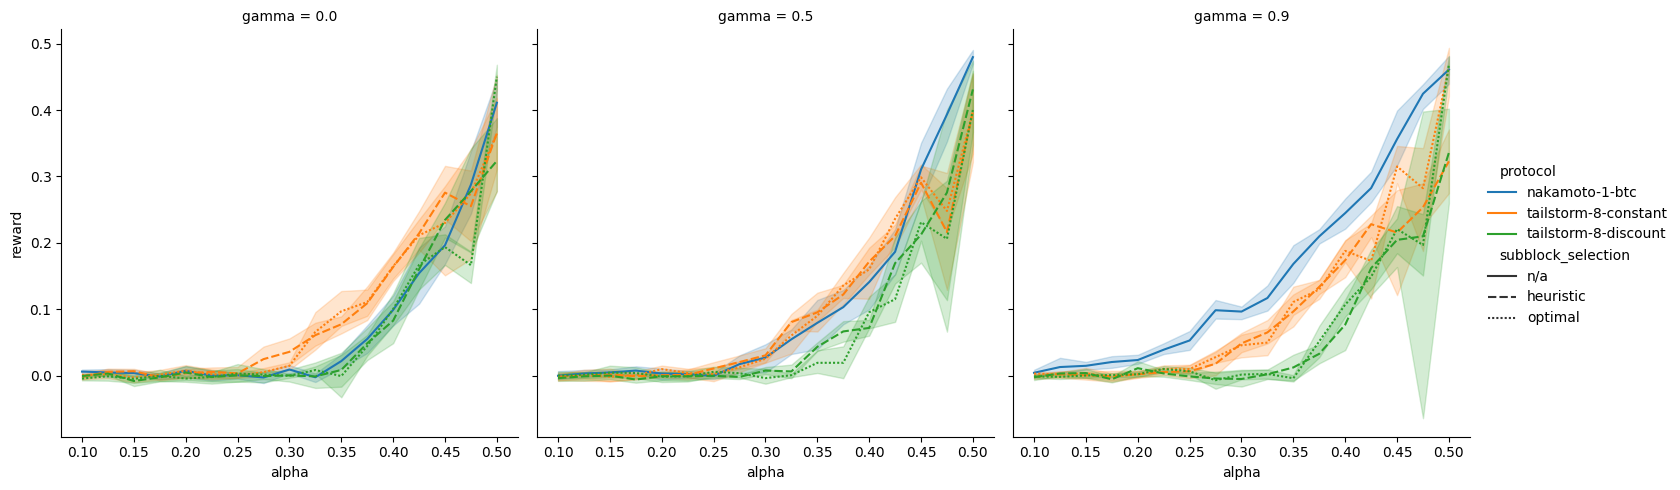

In [22]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Orphans

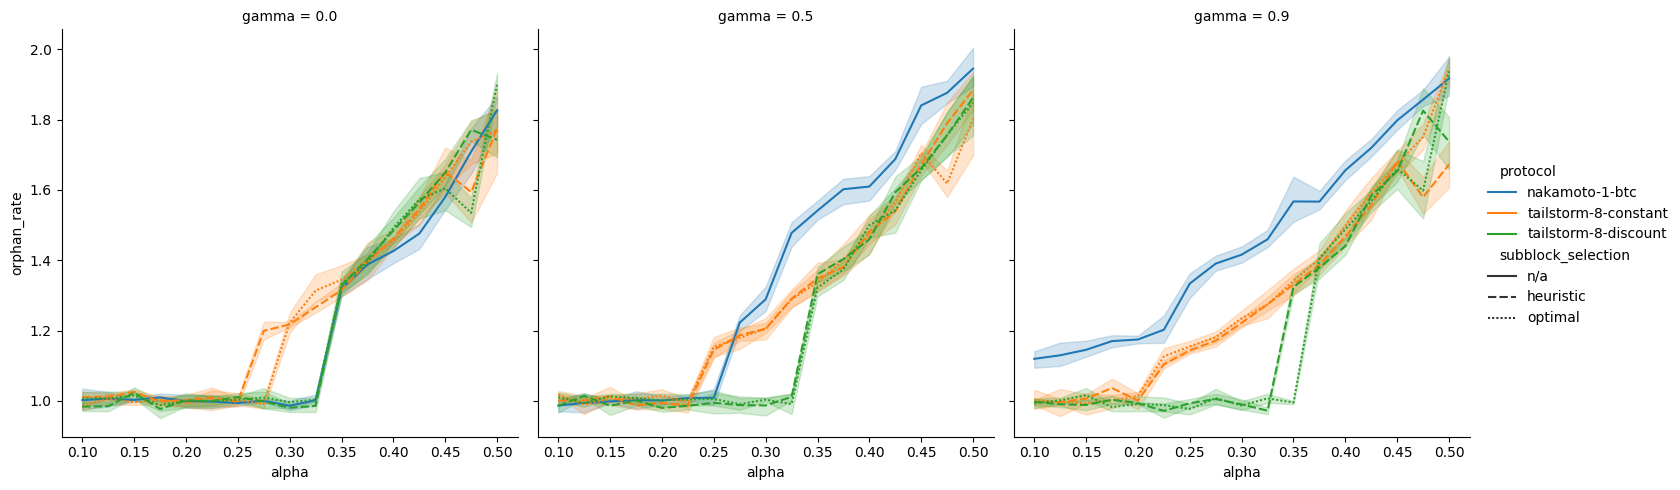

In [23]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        orphan_rate=d.episode_chain_time / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="orphan_rate",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Compress x-axis into single value

The resulting numbers are hard to interpret. Certainly, smaller implies less selfish-mining suspectibility, I'd say.

In [19]:
key = ["protocol", "k", "reward", "subblock_selection", "gamma"]
d = mm_episodes
d = (
    d.assign(
        raw=d.episode_reward_attacker / d.episode_progress,
        ben=d.episode_reward_attacker / d.episode_progress - d.alpha,
        patrik=d.episode_reward_attacker / d.episode_progress / d.alpha,
    )[key + ["raw", "ben", "patrik"]]
    .groupby(key)
    .mean()
)
d

raw       ben    patrik
protocol  k reward   subblock_selection gamma                              
nakamoto  1 btc      n/a                0.0    0.373535  0.073535  1.167690
                                        0.5    0.406607  0.106607  1.247788
                                        0.9    0.454498  0.154498  1.401583
tailstorm 8 constant heuristic          0.0    0.394234  0.094234  1.224363
                                        0.5    0.396898  0.096898  1.228519
                                        0.9    0.392268  0.092268  1.219999
                     optimal            0.0    0.391122  0.091122  1.213403
                                        0.5    0.398738  0.098738  1.231040
                                        0.9    0.406750  0.106750  1.254182
            discount heuristic          0.0    0.366407  0.066407  1.144150
                                        0.5    0.374651  0.074651  1.161234
                                        0.9    0.361093  0.061093  1.135102
                     optimal            0.0    0.365690  0.065690  1.139214
                                        0.5    0.364692  0.064692  1.143478
                                        0.9    0.370781  0.070781  1.154846

# Break-even point

My idea it to (per protocol & gamma)
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. P should be the first profitable policy after the break-even point
3. evaluate $P(\hat{\alpha})$ for different alphas around $\hat{\alpha}$
4. Ben-style reward should be negative for the smaller alpha, positive for the higher alphas.
5. fit a (linear) model on Ben-style rewards
6. return model's zero estimate as the break-even

Alternatively, check that point 4 holds, then minimize absolute value of Ben-style reward with Bayesian Optimization. Absolute value of Ben-style reward is 0 where the policy $P(\hat{\alpha})$ breaks even.